In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skvideo.io


import torch
import torch.nn as nn
import torch.nn.functional as F
from model.warplayer import warp
from model.refine import *



In [2]:
from model.RIFE import Model
model = Model()
model.load_model('train_log', -1)

/Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <5B3E6F5D-79A8-320C-BB50-9EDE6B0839DA> /Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# for param in model.flownet.parameters():
#     param.requires_grad = False

In [4]:
videodata = skvideo.io.vread("sample.mp4")
videodata.shape

(534, 720, 1280, 3)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def process_frame(arr):
  img0=(torch.tensor(arr.transpose(2, 0, 1)).to(device)/255.).unsqueeze(0)
  n, c, h, w = img0.shape
  ph = ((h - 1) // 32 + 1) * 32
  pw = ((w - 1) // 32 + 1) * 32
  padding = (0, pw - w, 0, ph - h)
  img0 = F.pad(img0, padding)
  return img0

def post_process(img):
  return img.cpu().detach().numpy().transpose(1, 2, 0)

In [6]:
frames=[0, 10, 5]
img0=process_frame(videodata[frames[0]])
img1=process_frame(videodata[frames[1]])
img_mid_actual=process_frame(videodata[frames[2]])

In [7]:
img_mid_pred=model.inference(img0, img1)

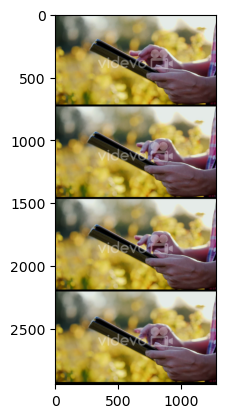

In [8]:
plt.imshow(np.concatenate([post_process(img0[0]), post_process(img1[0]), post_process(img_mid_actual[0]), post_process(img_mid_pred[0])]))

In [9]:
def get_ith_frame(data, i):
  img0=process_frame(data[i])
  img1=process_frame(data[i+2])
  img_mid_actual=process_frame(data[i+1])
  return torch.cat([img0, img1], dim=1), img_mid_actual

In [10]:
train_X, train_Y=None, None

for i in range(5):
    i_X, i_Y = get_ith_frame(videodata, i)
    if train_X==None:
        train_X, train_Y = i_X, i_Y
    else:
        train_X, train_Y = torch.cat([train_X, i_X]), torch.cat([train_Y, i_Y])

In [11]:
train_X.shape, train_Y.shape

(torch.Size([5, 6, 736, 1280]), torch.Size([5, 3, 736, 1280]))

In [12]:
res=model.update(train_X, train_Y, learning_rate=0.001)

In [13]:
res

(tensor([[[[1.8116e-01, 1.8322e-01, 1.8393e-01,  ..., 8.9831e-01,
            8.9920e-01, 8.9920e-01],
           [1.8245e-01, 1.8410e-01, 1.8425e-01,  ..., 8.9811e-01,
            8.9816e-01, 8.9777e-01],
           [1.8282e-01, 1.8423e-01, 1.8393e-01,  ..., 8.9810e-01,
            8.9647e-01, 8.9819e-01],
           ...,
           [6.0558e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [4.3392e-05, 0.0000e+00, 0.0000e+00,  ..., 1.3351e-05,
            0.0000e+00, 0.0000e+00],
           [8.8334e-05, 0.0000e+00, 0.0000e+00,  ..., 1.1253e-04,
            0.0000e+00, 0.0000e+00]],
 
          [[2.3986e-01, 2.4196e-01, 2.4272e-01,  ..., 9.2186e-01,
            9.2273e-01, 9.2265e-01],
           [2.4123e-01, 2.4286e-01, 2.4306e-01,  ..., 9.2167e-01,
            9.2172e-01, 9.2133e-01],
           [2.4161e-01, 2.4301e-01, 2.4275e-01,  ..., 9.2164e-01,
            9.2012e-01, 9.2168e-01],
           ...,
           [7.6771e-05, 0.0000e+00, 0.

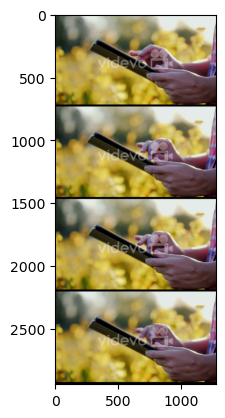

In [14]:
img_mid_pred=model.inference(img0, img1)
plt.imshow(np.concatenate([post_process(img0[0]), post_process(img1[0]), post_process(img_mid_actual[0]), post_process(img_mid_pred[0])]))